In [12]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os
import untangle
import ipywidgets as widgets
import tifffile
from MastodonFunctions import xml_features, csv_features, ordering_tracks, smoothing_filter, peak_detection, bulk_peak_analysis

# 4 - ROI creation for StarDist segmentation

For [StarDist](https://github.com/stardist/stardist) you need to label all the cells the field of view you use to train the network. Becuase the data can be very packed, what we do is to crop this field of view, always including our cell of interest, and we use this to train and later test the network. This Jupyter Notebook will serve to crop regions of interest around chosen cells (or random selected cells) so that then can be used to train and test the network. 

## Folder and data paths
In the next cell, you need to specify:
- ``path_xml``: Path and file name of the .xml file obtained from converting the data to HDF5/XML.
- ``path_csv``: Path and file name of the .csv file obtained from the tracks from Mastodon. You do not need to add the -edges or -vertices extension.
- ``path_hdf5``: Path and file name of the .h5 file obtained from converting the data to HDF5/XML.
- ``path_results``: Where to save the results like new tables or figures as PDFs.

In [4]:
# Position 1 and 2 correspond to two embryos from the same experiment
position = 2

In [5]:
# Path to .xml file generated when creating the .hdf5
path_xml = '../../Data/Position%d_20191213.xml'%position # Path to .xml file

# Path to the -edges.csv amd -vertices.csv files (You only need path + name of file without the -edges or -vertices extension)
path_csv = '../../Data/Position%d-All'%position

# Path to .hs file generated when creating the xml/hdf5 
path_hdf5 =  '../../Data/Position%d_20191213.h5'%position

## Image characteristics

Because we stored the data as an XML/HDF5, the .xml file contains all the metadata we need. We will now extract it in order to know pixel size, number of planes, image dimensions  and total number of timepoints. 

You only need to specify the temporal resolution in seconds that you used to acquire the data (``tr``). 

In [8]:
# Time resolution in seconds (how often do you acquire time points)
tr = 90
tr_min = round(tr/60,2) # in minutes

fts = xml_features(path_xml)

# Features from the image obtained from the .xml generated by BigData Viewer
print('The image has the following dimensions (XYZC): %d, %d, %d, %d'%(fts.width, fts.height, fts.n_slices, fts.channels))
print('There are %d frames in total.'%fts.n_frames)
print('Pixel Size: x = %.3g %s, y = %.3g %s z = %.2g %s'%(fts.x_pixel, fts.units, fts.y_pixel, fts.units, fts.z_pixel, fts.units))
print('There are %d Z-slices in total'%fts.n_slices)

The image has the following dimensions (XYZC): 2048, 2048, 150, 2
There are 299 frames in total.
Pixel Size: x = 0.347 micron, y = 0.347 micron z = 1.5 micron
There are 150 Z-slices in total


## Data organization: build the cell tracks

The function ``csv_features`` obtain all the features from each individual spot as a single unit. These spots are then rearranged according to their cell track and using the function ``ordering_tracks``. As a result, we get two new objects called ``spots`` and ``tracks``.

By pressing ``spots.`` + <kbd>TAB</kbd> or ``tracks.`` + <kbd>TAB</kbd>, a list will pop with all the different variables you can obtain from the spot object or the tracks obtject. 

In [6]:
# Function to obtain all the spots' information from the .csv file
spots = csv_features(path_csv, path_xml)

# Order the time series according to each individual cell
tracks = ordering_tracks(path_csv, path_xml)

## Plot all the cell tracks

Now that we organized the data, the next step is to plot the cell traces we obtained. For now, we will distinguish between dividing and non-dividing cells. 

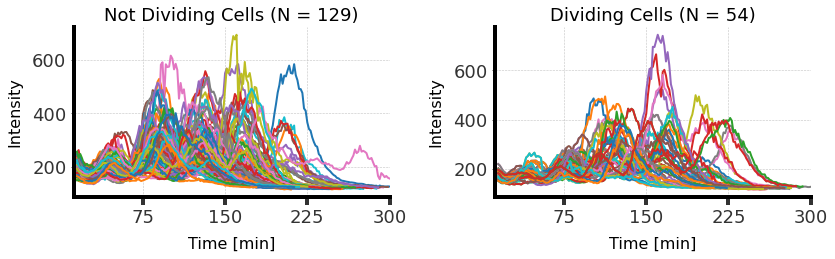

In [9]:
plt.figure(figsize=[12,4])
plt.style.use('mastodon_style.mplstyle')

# Cells that do not divide
plt.subplot(121)
for j in range(tracks.n_tracks_divs):
    if tracks.spots_features['DivID'][j] == 0:
        plt.plot(tracks.spots_features['Frames'][j], tracks.spots_features['Mean1'][j], linewidth=2)

plt.title('Not Dividing Cells (N = %d)'%spots.n_tracks, fontsize = 18)
plt.xlabel('Time [min]', fontsize=16)
locs, labels = plt.xticks()
plt.xticks(locs, map(int,np.round(locs*tr_min)))
plt.ylabel('Intensity', fontsize=16)
plt.xlim([8,200])

# Dividing Cells
plt.subplot(122)
for j in range(tracks.n_tracks_divs):
    if tracks.spots_features['DivID'][j] > 0:
        plt.plot(tracks.spots_features['Frames'][j], tracks.spots_features['Mean1'][j], linewidth=2)

plt.title('Dividing Cells (N = %d)'%tracks.n_division_tracks, fontsize = 18)
plt.xlabel('Time [min]', fontsize=16)
locs, labels = plt.xticks()
plt.xticks(locs, map(int,np.round(locs*tr_min)))
plt.ylabel('Intensity', fontsize=16)
plt.xlim([8,200])

plt.tight_layout()
plt.show()

## Cell-by-cell

Because we will have an identifier for each individual cell in order to be able to choose the ones we want to analyze in this notebook, we will plot below each individual cell with their ID. This ID can then be mapped back to the track ID from Mastodon in case you want to check the cell trace. 

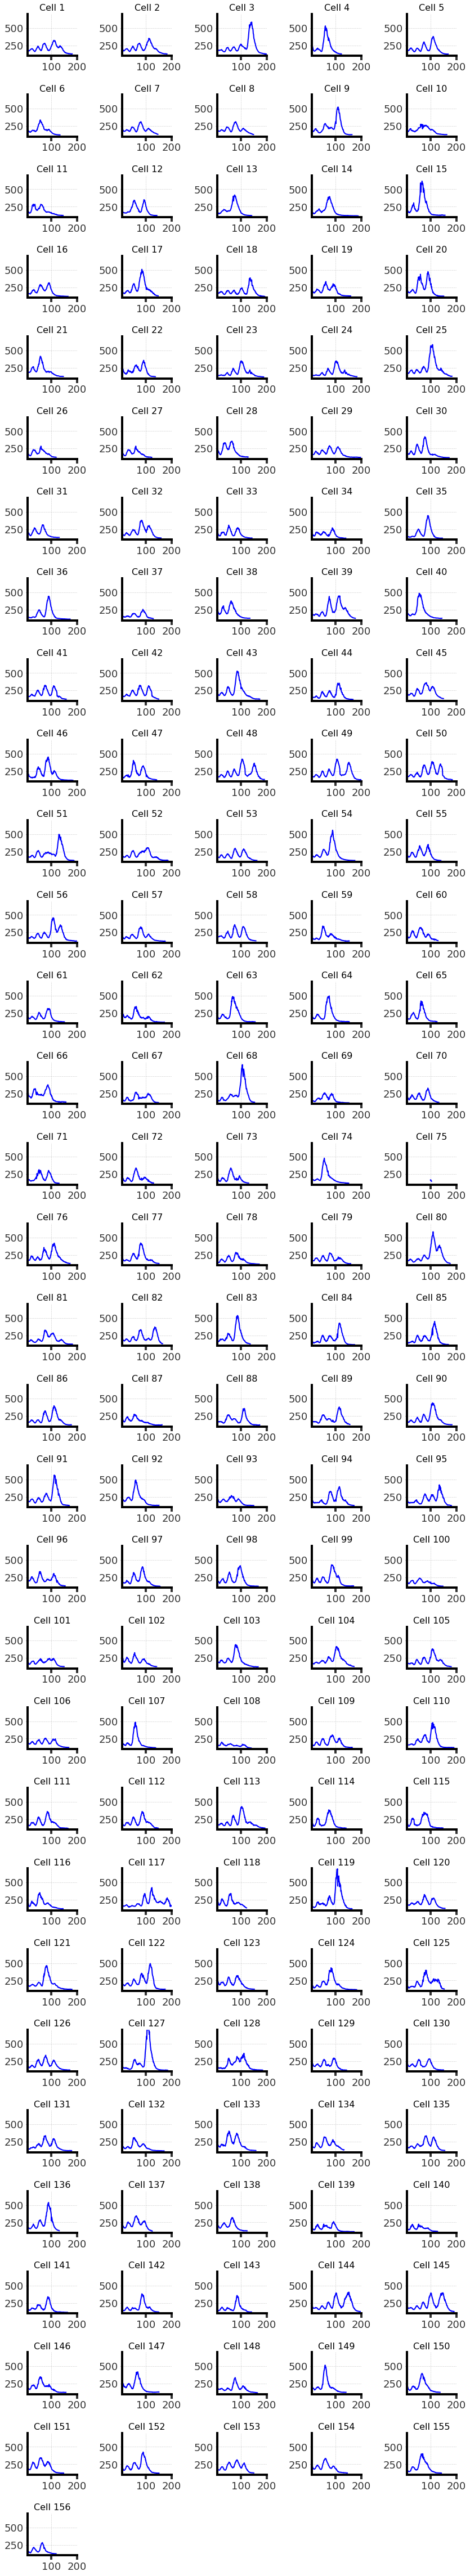

In [10]:
n_cols =  5
n_cells = tracks.n_tracks_divs
n_rows = np.ceil((n_cells + 1) / n_cols)
plot_num = 1
size_fig = n_rows*(10/n_cols)
# Initialize the figure size
fig = plt.figure(figsize=[12,size_fig])

for i in range(n_cells):
    
    # Update the number of subplots    
    ax = plt.subplot(int(n_rows), n_cols, plot_num, aspect='auto')
    plot_num += 1
    
    plt.plot(tracks.spots_features['Frames'][i], tracks.spots_features['Mean1'][i], 
             linewidth=2, color='blue')
    plt.title('Cell %d'%(i+1), fontsize=16)
    plt.xlim([8,200])
    plt.ylim([100,700])
    
plt.tight_layout()
plt.show()   

### Check for each cell, their track ID

For this notebook, each cell has been apointed with a number from 1-``N`` (``N`` being the number of cells you tracked). However, if you want to check which cell is the one you observe using Mastodon, here we provide the first track ID (so the track ID of the first timepoint of each cell). This way you can then check in Mastodon how does this cell behave. 

In [13]:
foo = list(np.arange(tracks.n_tracks_divs)) # List to use

 
# Function for the button to select user input and do work
def get_user_selection(a): # A default arg is needed here, I am guessing to pass self
    # Displays the current value of dropbox1 and dropbox two
    display(dropbox1.value)


# creation of a widget dropdown object called dropbox1
dropbox1 = widgets.Dropdown(
    options=foo, # Object to iterate over
    description='Cells ID:', # User defined 
    value=foo[1], # Default value selection
    rows=len(foo), # The number of rows to display when showing the box
    interactive=True, # This makes the box interactive, I believe this is true by default
);


# Create a UI object to display things.  There are other ways of organizing them.
ui = widgets.HBox([dropbox1]) # pass an array of widgets to the ui

# display the UI
display(ui)

In [20]:
track_ID_selected = tracks.spots_features['ID'][dropbox1.value][0]
frames_ID_selected = tracks.spots_features['Frames'][dropbox1.value][0]

print('The cell # %d has a Track ID # %d for Frame %d.'%(dropbox1.value, track_ID_selected, frames_ID_selected))

The cell # 46 has a Track ID # 15834 for Frame 10.


## Crop regions of interested surrounding the cells

In the following Jupyter cells, we will crop regions of interest surrounding the cells. We can choose how big these regions are, which cells (or if we want it to be random), and also the timepoints we want. 

### Re-arrange the data

In [15]:
trace_save = []
frames_save = []
div_save = []
x_save_ = []
y_save_ = []
z_save_ = []
id_save = []

for j in range(tracks.n_tracks_divs):
    if j!= 74:
        trace_save.append(tracks.spots_features['Mean1'][j])
        frames_save.append(tracks.spots_features['Frames'][j])
        x_save_.append(tracks.spots_features['X'][j])
        y_save_.append(tracks.spots_features['Y'][j])
        z_save_.append(tracks.spots_features['Z'][j])
        div_save.append(tracks.spots_features['DivID'][j])
        id_save.append(tracks.spots_features['ID'][j])

## Remove Time Registration 

If the data is registered, we will remove the time registration so that we have the same reference frame as in the embryo for later analysis. 

### Apply transformations

In [16]:
n_cells = len(frames_save)

# Fill the timepoints where there are no cells tracked with nan
tracks_save = np.ones((n_cells, fts.n_frames))*np.nan

# Save also the x,y positions
x_save = np.ones((n_cells, fts.n_frames))*np.nan
y_save = np.ones((n_cells, fts.n_frames))*np.nan
z_save = np.ones((n_cells, fts.n_frames))*np.nan

# For each track 
for i in range(n_cells):
    # Add the tracked spot to the specific time frame to which it corresponds
    for j,val in enumerate(frames_save[i]):
        tracks_save[i,val] = trace_save[i][j]
        x_save[i,val] = x_save_[i][j]
        y_save[i,val] = y_save_[i][j]
        z_save[i,val] = z_save_[i][j]

In [19]:
obj = untangle.parse(path_xml)

x_save_r = []
y_save_r = []
z_save_r = []
    
time_points = fts.n_frames

for j in range(n_cells):
    
    aux_x = []
    aux_y = []
    aux_z = []
    
    for i in range(0,(time_points)*fts.channels,fts.channels):
        
        # XYZ coordinates from mastodon
        xyz_coord = np.array([x_save[j][int(i/2)],y_save[j][int(i/2)],z_save[j][int(i/2)]]).reshape(-1,1)
    
        # Registration from .xml
        registration = np.array(obj.SpimData.ViewRegistrations.ViewRegistration[i].ViewTransform[0].affine.cdata.split(),dtype=float).reshape(3,4)
        
        # Rotation matrix
        R = registration[:,:3] 
        
        # Inverse of rotation matrix
        R_inv = np.linalg.inv(R)
        
        # Translation matrix
        T = registration[:,-1].reshape(-1,1)
        
        final = R_inv@(xyz_coord-T)
        
        # Save xyz de-registered coordinates
        aux_x.append(final[0][0])
        aux_y.append(final[1][0])
        aux_z.append(final[2][0])

    x_save_r.append(aux_x)
    y_save_r.append(aux_y)
    z_save_r.append(aux_z)

## Create ROIs for Stardist

Belowe we have the parameters of how we can crop the data from the HDF5 and how many cells we ant to use to train:
- ``n_cells_train``: Number of cells we want to crop for training
- ``n_tps_train``: Number of tiempoints per cell we will use for the training
- ``x_crop``, ``y_crop``, ``z_crop``: How big in pixels we want the voxel to be around the cell
- ``channel``: which channel do you want to use (usually one with nuclei expression)
- ``subsampling``: If you want to use any subsampled version of the cells

In [ ]:
n_cells_train = 5 # Number of cells for the trainning
n_tps_train = 5 # Number of timepoints per cell for the trainning

# Cropping
x_crop = 15
y_crop = 15
z_crop = 4

# channel 
channel = 1

# Subsampling 
subsampling = 0

In [199]:
def crop_hdf5(x,y,z,x_pixel,y_pixel,z_pixel,path_hdf5,tp,cell,x_crop,y_crop,z_crop,data_path):
    # Convert data into 
    x_val = int(np.round(x/x_pixel))
    y_val = int(np.round(y/y_pixel))
    z_val = int(np.round(z/z_pixel))
    
    # Read the data
    f = h5py.File(path_hdf5, 'r')
    
    #Get the HDF5 group
    group = f['t%.5d'%tp]
    
    # Create the Z stack
    aux = []
    z_vals_crop = np.arange(z_val-z_crop,z_val+z_crop,1)
    for i in z_vals_crop:
        aux += [group[channel][subsampling]['cells'][i][y_val-y_crop:y_val+y_crop,x_val-x_crop:x_val+x_crop]]
        
    tifffile.imsave('%s/Cell_%d_T_%.3d.tif'%(data_path, cell,tp), np.array(aux))

In [216]:
# Create a list to save the tiff crops for stardist
training_data_path = os.path.join("./","training-data")
if not os.path.exists(training_data_path):
    os.mkdir(training_data_path)

In [217]:
# channel 
channel = 's0%d'%channel

# Subsampling 
subsampling = str(subsampling)

for i in range(n_cells_train):
    # Select a random number of a cell
    cell_rand = np.random.randint(n_cells)
    
    # Choose no nan data
    no_nan_tp = np.arange(0,time_points-1,1)[~np.isnan(x_save_r[cell_rand])]
    tps_rand = np.random.choice(no_nan_tp, n_tps_train)
    
    # For each timepoint, for that cell
    for j in tps_rand:
        # X,Y,Z values for that timepoint & for that cell
        x = x_save_r[cell_rand][j]
        y = y_save_r[cell_rand][j]
        z = z_save_r[cell_rand][j]
        
        crop_hdf5(x,y,z,fts.x_pixel,fts.y_pixel,fts.z_pixel,path_hdf5,j,cell_rand,x_crop,y_crop,z_crop,training_data_path)
        

In [59]:
x_val = int(np.round(x_save_r[cell][tp]/fts.x_pixel))
y_val = int(np.round(y_save_r[cell][tp]/fts.y_pixel))
z_val = int(np.round(z_save_r[cell][tp]/fts.z_pixel))

In [60]:
# Read the data
f = h5py.File(path_hdf5, 'r')
    
#Get the HDF5 group
group = f['t%.5d'%tp]

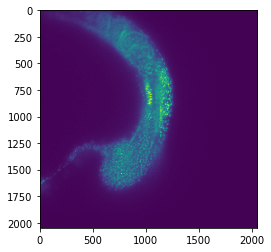

In [62]:
plt.imshow(group[channel][subsampling]['cells'][z_val])

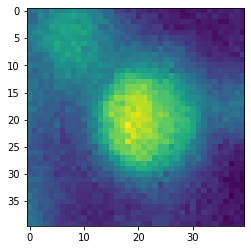

In [88]:
plt.imshow(group[channel][subsampling]['cells'][z_val][y_val-y_crop:y_val+y_crop,x_val-x_crop:x_val+x_crop])

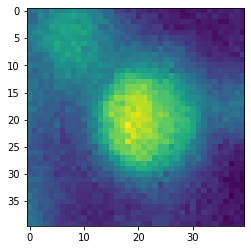

In [72]:
plt.imshow(group[channel][subsampling]['cells'][z_val][y_val-y_crop:y_val+y_crop,x_val-x_crop:x_val+x_crop])